In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# --------------------------------------------------------------------
# 1. Load data
# --------------------------------------------------------------------
df = pd.read_excel(
    r'/Users/marclambertes/Downloads/Wyscout/Premier League 2023-2024.xlsx',
    index_col='Player'
)

# --------------------------------------------------------------------
# 2. Optional filtering
# --------------------------------------------------------------------
df = df[df['Minutes played'] >= 500]

# Example optional filters (comment out or adjust as needed):
# df = df[df['League'] == 'Eredivisie']
# df = df[(df['League'] != 'Belarus') & (df['League'] != 'Russian Super League') & (df['League'] != 'Ukraine')]
# df = df[(df['Team'] != 'Chelsea')]

# --------------------------------------------------------------------
# 3. Drop unneeded columns
# --------------------------------------------------------------------
cols_to_drop = [
    'Minutes played', 
    'Matches played', 
    'Birth country',
    'Passport country', 
    'Height', 
    'Weight'
]
df = df.drop(columns=cols_to_drop)

# --------------------------------------------------------------------
# 4. Handle missing values
# --------------------------------------------------------------------
if df.isna().values.any():
    df = df.fillna(0)

# --------------------------------------------------------------------
# 5. Separate numeric and categorical columns
# --------------------------------------------------------------------
num_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
# We'll keep only: Team, Team within selected timeframe, Position (and possibly League) from the original
df = df[['Team', 'Team within selected timeframe', 'Position'] + num_cols]

# --------------------------------------------------------------------
# 6. Scale numeric features
# --------------------------------------------------------------------
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# --------------------------------------------------------------------
# 7. Compute Pearson correlation of players with each other
# --------------------------------------------------------------------
# By transposing, we make each player's stats become a column => .corr() => NxN matrix
# where N = number of players. Indices and columns will be player names.
pearson_corr = df[num_cols].T.corr(method='pearson')

# --------------------------------------------------------------------
# 8. Define a function to retrieve similar players by correlation
# --------------------------------------------------------------------
def get_similar_players(player_name, top_n=300):
    """
    Returns a list of tuples: (OtherPlayerName, Team, Position, Correlation)
    sorted from highest (most similar) to lowest correlation.
    """
    # 8a. Get the correlation Series for the given player
    # This will be all players' correlation to 'player_name'
    player_correlations = pearson_corr[player_name]
    
    # 8b. Sort by descending correlation
    player_correlations = player_correlations.sort_values(ascending=False)
    
    # 8c. Remove the player themselves (correlation=1.0)
    if player_name in player_correlations.index:
        player_correlations = player_correlations.drop(player_name)
    
    # 8d. Take the top N
    top_scores = player_correlations.head(top_n)
    
    # 8e. Convert to list of (player, team, position, raw_correlation)
    similar_players = []
    for other_player, corr_value in top_scores.items():
        team = df.loc[other_player, 'Team within selected timeframe']
        position = df.loc[other_player, 'Position']
        similar_players.append((other_player, team, position, corr_value))
    
    return similar_players

# --------------------------------------------------------------------
# 9. Prompt user for a player name
# --------------------------------------------------------------------
player_name = input("Enter a player name: ")

# --------------------------------------------------------------------
# 10. Get similar players based on correlation
# --------------------------------------------------------------------
similar_players = get_similar_players(player_name)

# --------------------------------------------------------------------
# 11. Convert correlation (-1 to +1) into a 0-100 similarity scale
# --------------------------------------------------------------------
# correlation = -1 --> 0%
# correlation =  1 --> 100%
similar_players_scaled = []
for (other_player, team, position, corr) in similar_players:
    similarity_score = (corr + 1) / 2 * 100
    similar_players_scaled.append((other_player, team, position, similarity_score))

# --------------------------------------------------------------------
# 12. Print results
# --------------------------------------------------------------------
print(f"Players similar to {player_name} (by Pearson correlation):\n")
for player, team, position, similarity_score in similar_players_scaled:
    print(f"Player: {player}")
    print(f"Team: {team}")
    print(f"Position: {position}")
    print(f"Similarity Score: {similarity_score:.2f}%")
    print("-" * 40)

# --------------------------------------------------------------------
# 13. Write results to Excel
# --------------------------------------------------------------------
output_filename = r'/Users/marclambertes/Python/similar players.xlsx'
similar_players_df = pd.DataFrame(
    similar_players_scaled, 
    columns=['Player', 'Team', 'Position', 'Similarity Score']
)
similar_players_df.to_excel(output_filename, index=False)
print(f"\nSimilar players saved to {output_filename}")


Enter a player name: Mohamed Salah
Players similar to Mohamed Salah (by Pearson correlation):

Player: C. Palmer
Team: Chelsea
Position: AMF, RAMF
Similarity Score: 91.94%
----------------------------------------
Player: Son Heung-Min
Team: Tottenham Hotspur
Position: CF, LAMF
Similarity Score: 90.36%
----------------------------------------
Player: João Pedro
Team: Brighton
Position: CF, AMF
Similarity Score: 87.47%
----------------------------------------
Player: B. Saka
Team: Arsenal
Position: RWF, RW
Similarity Score: 87.27%
----------------------------------------
Player: D. Núñez
Team: Liverpool
Position: CF
Similarity Score: 85.95%
----------------------------------------
Player: E. Haaland
Team: Manchester City
Position: CF
Similarity Score: 85.22%
----------------------------------------
Player: A. Isak
Team: Newcastle United
Position: CF
Similarity Score: 83.99%
----------------------------------------
Player: B. Mbeumo
Team: Brentford
Position: RWF, CF
Similarity Score: 83.7

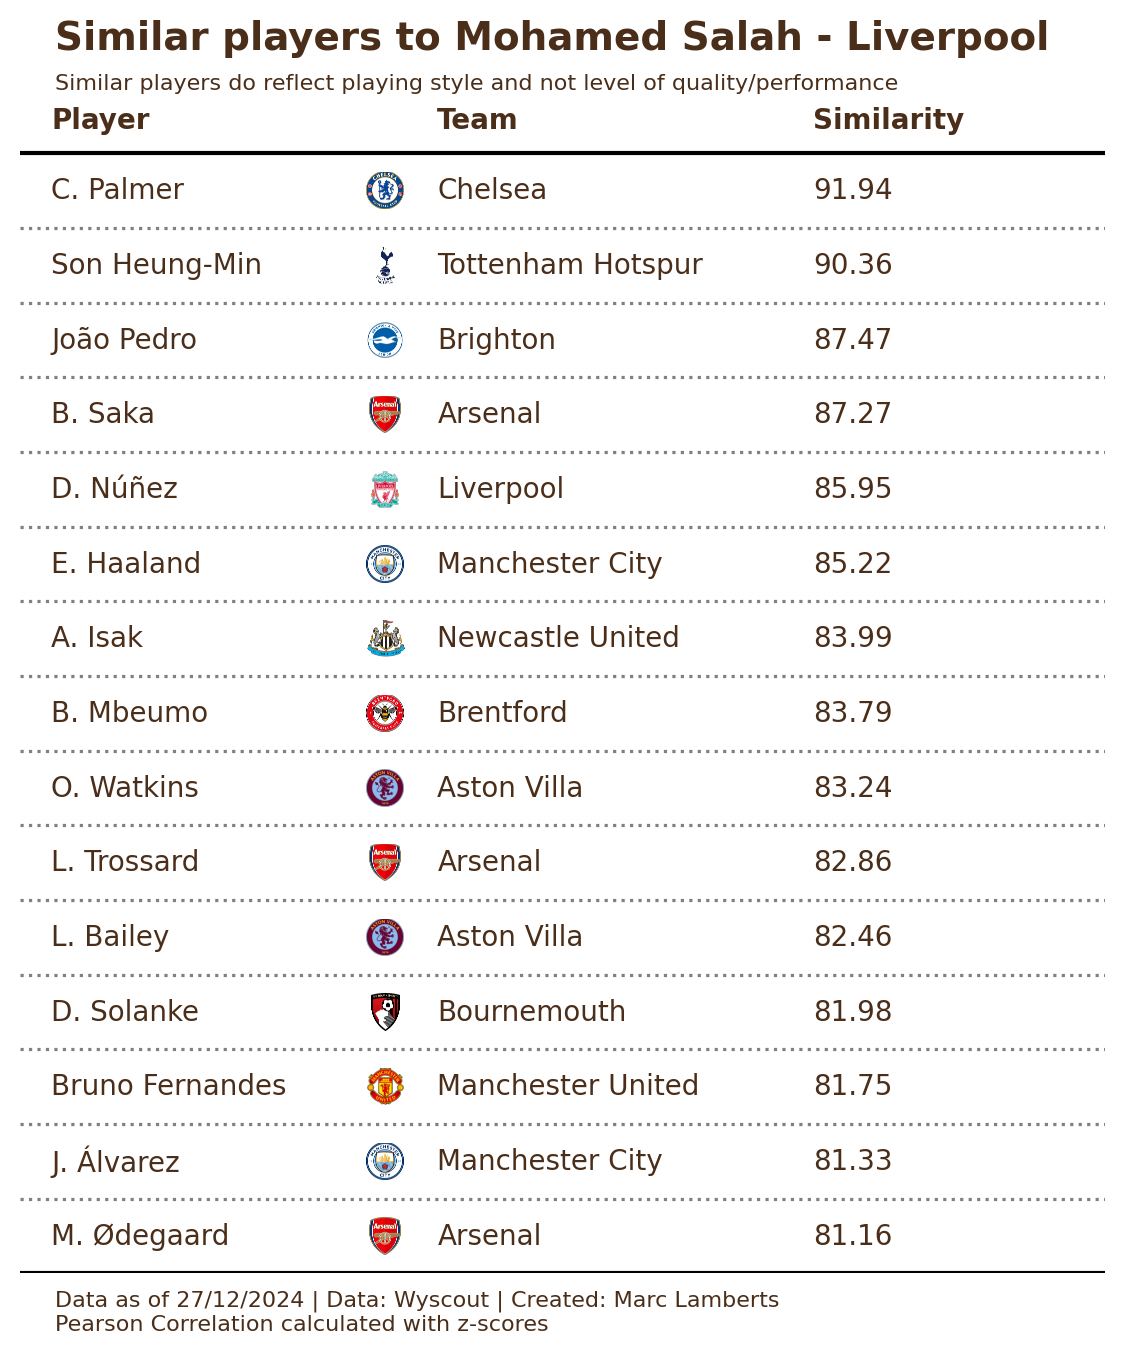

In [3]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter


df = pd.read_excel('/Users/marclambertes/Python/similar players.xlsx')
#df['League'] = df['League'].str.split(' - ').str[0]

#df = df[(df['League'] != 'Armenia')]
#df = df[df['Age'] <= 23]

df = df.rename(columns={'Similarity Score': 'Similarity'})
def ax_logo(team, ax,):
    path = r'/Users/marclambertes/Downloads/Images'
    club_icon = Image.open('%s/%s.png' %(path,team))
    ax.imshow(club_icon)
    ax.axis('off')
    return ax
df['Similarity'] = (df['Similarity']).round(2)



indexdf = df.head(15)[['Player', 'Team', 'Similarity']].reset_index(drop=True)
indexdf_short=indexdf[::-1]

fig = plt.figure(figsize=(7,8), dpi=200)
ax = plt.subplot()

ncols = len(indexdf_short.columns.tolist())+1
nrows = indexdf_short.shape[0]

ax.set_xlim(0, ncols + 1.2)
ax.set_ylim(0, nrows + 1.5)

# lgs = ['J1', 'J2', 'Ekstraklasa', 'J3']
# if lg in lgs:
positions = [0.15, 2.0, 3.8, 5.7]
# else:
#     positions = [0.25, 2.25, 3.75, 4.5, 5.25]
columns = indexdf_short.columns.tolist()

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if 'xG per 90' in column:
            text_label = f'{indexdf_short[column].iloc[i]:,.2f}'
            weight = 'regular'
        else:
            text_label = f'{indexdf_short[column].iloc[i]}'
            weight = 'regular'
        ax.annotate(
            xy=(positions[j], i + .5),
            text = text_label,
            ha='left',
            va='center', color='#4A2E19',
            weight=weight
        )

# Add column names
column_names = columns
for index, c in enumerate(column_names):
        ax.annotate(
            xy=(positions[index], nrows + .25),
            text=column_names[index],
            ha='left',
            va='bottom',
            weight='bold', color='#4A2E19'
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

ax.set_axis_off()

DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
# -- Add nation axes
ax_point_1 = DC_to_NFC([2.25, 0.25])
ax_point_2 = DC_to_NFC([2.75, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
for x in range(0, nrows):
    ax_coords = DC_to_NFC([1.5, x + .25])
    flag_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    ax_logo(indexdf_short['Team'].iloc[x], flag_ax,)

fig.text(
    x=0.15, y=.87,
    s='Similar players to Mohamed Salah - Liverpool',
    ha='left',
    va='bottom',
    weight='bold',
    size=14, color='#4A2E19'
)
fig.text(
    x=0.15, y=0.10,
    s='Data as of 27/12/2024 | Data: Wyscout | Created: Marc Lamberts\nPearson Correlation calculated with z-scores',
    ha='left',
    va='top',
    weight='regular',
    size=8, color='#4A2E19'
)

fig.text(
    x=0.15, y=0.86,
    s='Similar players do reflect playing style and not level of quality/performance',
    ha='left',
    va='top',
    weight='regular',
    size=8, color='#4A2E19'
)

plt.savefig('Similar Players - Mohamed Salah3.png',dpi=750,bbox_inches = 'tight', facecolor='white')
#plt.savefig('Similar Players - Momiki.pdf', dpi=750, bbox_inches='tight', facecolor='white')
